In [ ]:
!nvidia-smi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
filtered_train_data = pd.read_csv("../data/merged_df.csv")

In [6]:
filtered_train_data.head()

,image_id,x,y,width,height,english_text,hindi_text
0,2341043,324,197,44,22,Silver bracelet around woman's neck.,महिला गर्दन के आसपास सिल्वर ब्रेसेलेट
1,2365053,215,242,243,130,piece of sandwich stuff with lot of meat,सैंडविच का भाग बहुत सारे मांस से भड़ा हुआ
2,2380933,0,0,410,497,a black and white picture of a park scene,एक पार्क दृश्य का काला और सफेद चित्र
3,2402778,19,2,166,209,large rectangular mirror over sink,सिंक पर बड़ा आयताकार दर्पण
4,2396975,216,185,237,82,a car loading food on a plane,हवाई जहाज पर खाना भारित करता हुआ वाहन


In [4]:
filtered_train_data.dropna(inplace = True)
filtered_train_data.drop_duplicates(inplace = True)

In [5]:
filtered_train_data.shape

(31520, 7)

In [7]:
filtered_train_data['en_len'] = filtered_train_data['english_text'].apply(lambda x : len(x.split(" ")))
filtered_train_data['hi_len'] = filtered_train_data['hindi_text'].apply(lambda x : len(x.split(" ")))

filtered_train_data = filtered_train_data[(filtered_train_data['hi_len'] <= 50) & (filtered_train_data['en_len'] <= 50) ]

In [10]:
print(filtered_train_data.shape)
filtered_train_data.head()

(31520, 9)


,image_id,x,y,width,height,english_text,hindi_text,en_len,hi_len
0,2341043,324,197,44,22,Silver bracelet around woman's neck.,महिला गर्दन के आसपास सिल्वर ब्रेसेलेट,5,6
1,2365053,215,242,243,130,piece of sandwich stuff with lot of meat,सैंडविच का भाग बहुत सारे मांस से भड़ा हुआ,8,9
2,2380933,0,0,410,497,a black and white picture of a park scene,एक पार्क दृश्य का काला और सफेद चित्र,9,8
3,2402778,19,2,166,209,large rectangular mirror over sink,सिंक पर बड़ा आयताकार दर्पण,5,5
4,2396975,216,185,237,82,a car loading food on a plane,हवाई जहाज पर खाना भारित करता हुआ वाहन,7,8


In [11]:
# 1. Add <sos> and <eos> tokens
filtered_train_data['en'] = filtered_train_data['english_text'].apply(lambda x: '<sos> ' + ' '.join(str(x).split()[::-1]) + ' <eos>') # reversing the inut sequence
filtered_train_data['fr'] = filtered_train_data['hindi_text'].apply(lambda x: '<sos> ' + str(x) + ' <eos>')

# 2. Tokenization (word level)
en_tokenizer = Tokenizer(filters='', lower=False)
fr_tokenizer = Tokenizer(filters='', lower=False)

en_tokenizer.fit_on_texts(filtered_train_data['en'])
fr_tokenizer.fit_on_texts(filtered_train_data['fr'])

en_sequences = en_tokenizer.texts_to_sequences(filtered_train_data['en'])
fr_sequences = fr_tokenizer.texts_to_sequences(filtered_train_data['fr'])

# 3. Padding
max_en_len = max(len(seq) for seq in en_sequences)
max_fr_len = max(len(seq) for seq in fr_sequences)

en_padded = pad_sequences(en_sequences, maxlen=max_en_len, padding='post')
fr_padded = pad_sequences(fr_sequences, maxlen=max_fr_len, padding='post')

In [16]:
max_en_len , max_fr_len

(27, 33)

In [12]:
# Define model parameters
embedding_dim = 256
lstm_units = 256

# Vocabulary size (from tokenizers)
vocab_size_en = len(en_tokenizer.word_index) + 1  # English vocab
vocab_size_fr = len(fr_tokenizer.word_index) + 1  # French vocab

# --- Encoder ---
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=vocab_size_en, output_dim=embedding_dim , mask_zero = True)(encoder_input)
encoder_lstm = LSTM(units=lstm_units, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim,mask_zero = True)(decoder_input)
decoder_lstm = LSTM(units=lstm_units, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(units=vocab_size_fr, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# --- Define the full model ---
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

In [13]:
# Model definition
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 256)         │       2,134,784 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, None)              │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 256)         │       2,225,152 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         525,312 │ embedding[0][0],           │
│                               │ 256), (None, 256)]        │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         525,312 │ embedding_1[0][0],         │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 8692)        │       2,233,844 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 7,644,404 (29.16 MB)

 Trainable params: 7,644,404 (29.16 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Shift fr_padded to create decoder_target_data (by removing <sos> token or shifting)
decoder_target_data = fr_padded[:, 1:]  # Remove first token
decoder_input_data = fr_padded[:, :-1]  # Remove last token

# Train the model
history = model.fit(
    [en_padded, decoder_input_data],  # English sentence + Decoder input
    decoder_target_data[..., np.newaxis],  # Targets (reshaped to add last dimension)
    batch_size=64,
    epochs=1,
    validation_split=0.2
)

394/394 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.3683 - loss: 5.2787 - val_accuracy: 0.0908 - val_loss: 3.8336


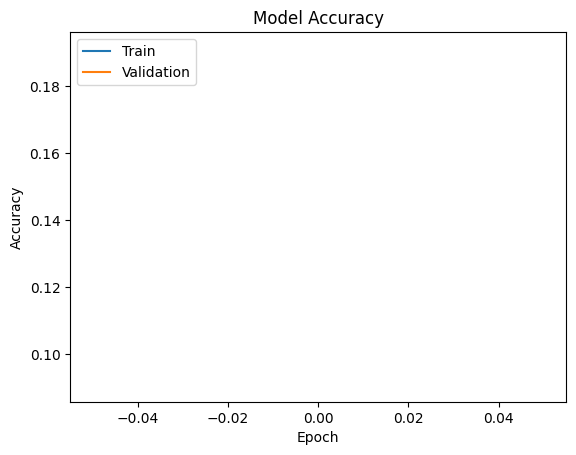

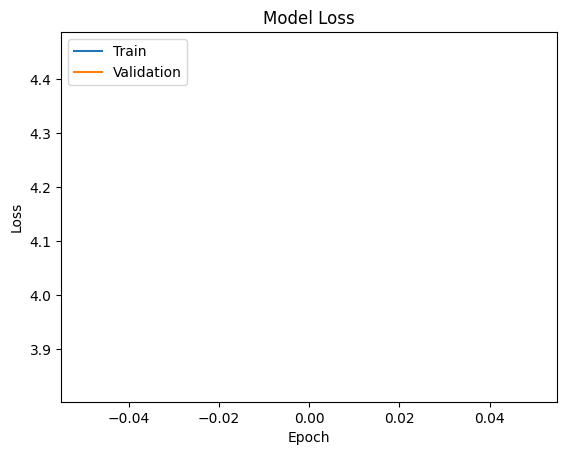

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# en : If I lose, likewise.	Si jamais nous perdons,     fr : je le ferai également.
# en : There's an awful lot of questions.	              fr : Beaucoup de questions se posent.
# en : A king with 14 wives       	                    fr : Un roi et ses 14 épouses

# Inference setup
input_sentence = "<sos> Accerciser Accessibility Explorer <eos>"

# Convert to sequence
input_seq = en_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_en_len, padding='post')

# Start the decoder input with just <sos>
decoder_input_tokens = [fr_tokenizer.word_index['<sos>']]

# Placeholder for output sentence
decoded_sentence = ''

# Predict tokens step-by-step
for _ in range(max_fr_len):
    # Prepare decoder input
    decoder_input = np.array(decoder_input_tokens).reshape(1, -1)

    # Predict next token
    output_tokens = model.predict([input_seq, decoder_input], verbose=0)
    predicted_token = np.argmax(output_tokens[0, -1, :])

    # Convert token to word
    predicted_word = fr_tokenizer.index_word.get(predicted_token, '')

    if predicted_word == '<eos>':
        break

    decoded_sentence += ' ' + predicted_word

    # Append predicted token to decoder input for next time step
    decoder_input_tokens.append(predicted_token)

# Print final decoded sentence
print(decoded_sentence.strip())

है


In [19]:
# en : If I lose, likewise.                             fr : Si je perds, pareil
# en : There's an awful lot of questions.	              fr : Beaucoup de questions se posent.
# en : A king with 14 wives       	                    fr : Un roi et ses 14 épouses

In [36]:
model.save("model.h5")